In [ ]:
import numpy as np
import pandas as pd
import sys
import os
import json
from ast import literal_eval
from tqdm import tqdm
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn import preprocessing
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingClassifier

from sklearn.tree import plot_tree



from google.colab import drive
drive.mount('/content/drive', force_remount=True)
directory_path = '/content/drive/MyDrive/Redes/'
directory_files = os.listdir(directory_path)

date_string = "21 June, 2009"
max_date = datetime.strptime(date_string, "%d %B, %Y")
max_index = 0
for index, file in enumerate(directory_files):
  if(file.split("_")[0] == 'requisicoes'):
    date_local = datetime.strptime(file.split("_")[1], '%Y-%m-%d')
    if(date_local > max_date):
      max_date = date_local
      max_index = index

Mounted at /content/drive


In [ ]:
dataRaw = pd.read_csv("/content/drive/MyDrive/Redes/"+directory_files[max_index], on_bad_lines='skip', sep=",")
dataRaw = dataRaw.sample(frac=1, random_state=42).reset_index(drop=True)

dataRaw = dataRaw.loc[dataRaw['Erlang'] >= 40]

dataBlock = dataRaw.loc[dataRaw['Aceita']==0,]

dataNotBlock = dataRaw.loc[dataRaw['Aceita']==1,]

dataConcatenado = pd.concat([dataBlock, dataNotBlock])

dataRefinado = dataConcatenado.drop([
 'ArrivalTime',
 'Path',
 'PathBkp',
 'SlotsAlocados',
 'SlotsAlocadosBkp',
 'SlotsAdicionaisBkp',
 'Duracao',
 'DuracaoBkp',
 'TimeBkp',
 'HoldingSlotPrim',
 'HoldingSlotBkp',
 'EstrAllocate',
 'TimeSimulacao',
 'Time',
 'Repli',
 'idReq'
], axis=1)

print('Requisições aceitas: ', len(dataNotBlock))
print('Requisições bloqueadas: ', len(dataBlock))

dataRefinado

Requisições aceitas:  605603
Requisições bloqueadas:  94397


,Source,Destination,NumLinkPath,NumLinkBkp,NumSlots,NumSlotsBkp,Data,Deadline,SlotTotalUtil,UtilizacaoRede,SlotsPathUtil,UtilizacaoPath,SlotsBkpUtil,UtilizacaoBkp,DispPath,DispPathBkp,Erlang,Aceita
0,2,4,1,0,7,0,500,5,4628,73,271,90,487,81,True,False,100,0
12,4,12,2,0,8,0,500,10,4531,71,342,57,860,71,True,False,90,0
20,14,7,3,0,7,0,500,10,3909,62,630,70,1252,69,True,False,60,0
21,7,9,2,0,3,0,500,25,4228,67,527,87,689,76,True,False,70,0
23,9,8,1,0,7,0,500,10,4671,74,271,90,969,80,True,False,100,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999989,11,3,3,4,2,2,500,50,4694,74,726,80,883,73,True,True,100,1
999992,5,4,1,4,2,3,500,25,4366,69,259,86,954,79,True,True,80,1
999994,3,1,1,2,2,2,100,5,4017,63,53,17,370,61,True,True,70,1
999996,2,9,5,4,20,20,500,5,2481,39,875,58,505,42,True,True,40,1


In [ ]:
dataRefinadoNew = dataRefinado.drop([
 'NumLinkPath',
 'Source',
 'Destination',
 'NumLinkBkp',
 'NumSlots',
 'NumSlotsBkp',
 'SlotsPathUtil',
 'UtilizacaoPath',
 'DispPath',
 'DispPathBkp'
], axis=1)

name = 'baseTreinamento_'+(datetime.now()+ timedelta(days=0)).strftime("%Y-%m-%d")+'_.csv'
dataRefinadoNew.to_csv(name, index=False)

!cp $name "drive/My Drive/Redes/"

dataRefinadoNew

,Data,Deadline,SlotTotalUtil,UtilizacaoRede,SlotsBkpUtil,UtilizacaoBkp,Erlang,Aceita
0,500,5,4628,73,487,81,100,0
12,500,10,4531,71,860,71,90,0
20,500,10,3909,62,1252,69,60,0
21,500,25,4228,67,689,76,70,0
23,500,10,4671,74,969,80,100,0
...,...,...,...,...,...,...,...,...
999989,500,50,4694,74,883,73,100,1
999992,500,25,4366,69,954,79,80,1
999994,100,5,4017,63,370,61,70,1
999996,500,5,2481,39,505,42,40,1


In [ ]:
print('Aceita: ',len(dataRefinadoNew.query('Aceita == 1')))
print('Bloq: ',len(dataRefinadoNew.query('Aceita == 0')))

Aceita:  605603
Bloq:  94397


In [ ]:

dataRefinadoNewY = dataRefinadoNew['Aceita']
dataRefinadoNewX = dataRefinadoNew.drop([
 'Aceita',
], axis=1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(pd.DataFrame(dataRefinadoNewX))

dataRefinadoNewXNormalizado = pd.DataFrame(scaler.transform(dataRefinadoNewX))

x_train, x_test, y_train, y_test = train_test_split(dataRefinadoNewXNormalizado, dataRefinadoNewY, test_size=0.20,stratify = dataRefinadoNewY)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20,stratify = y_train)

dataRefinadoNewXNormalizado

,0,1,2,3,4,5,6
0,1.0,0.000000,0.916073,0.9125,0.253514,0.861702,1.000000
1,1.0,0.111111,0.896873,0.8875,0.447683,0.755319,0.833333
2,1.0,0.111111,0.773753,0.7750,0.651744,0.734043,0.333333
3,1.0,0.444444,0.836896,0.8375,0.358667,0.808511,0.500000
4,1.0,0.111111,0.924584,0.9250,0.504425,0.851064,1.000000
...,...,...,...,...,...,...,...
699995,1.0,1.000000,0.929137,0.9250,0.459656,0.776596,1.000000
699996,1.0,0.444444,0.864212,0.8625,0.496616,0.840426,0.666667
699997,0.0,0.000000,0.795131,0.7875,0.192608,0.648936,0.500000
699998,1.0,0.000000,0.491093,0.4875,0.262884,0.446809,0.000000


In [ ]:

clf1 = KNeighborsClassifier(n_neighbors = 4)

scores = cross_val_score(clf1, x_train, y_train)
print('Cross validation KNN: ', np.mean(scores))

clf2 = DecisionTreeClassifier(criterion = 'gini', max_depth=6)

scores = cross_val_score(clf2, x_train, y_train)
print('Cross validation Decision Tree: ',np.mean(scores))

clf3 = RandomForestClassifier(n_estimators = 50,
                max_depth=6,
                criterion = 'gini',
                random_state=0)
scores = cross_val_score(clf3, x_train, y_train)
print('Cross validation Forest: ', np.mean(scores))

eclf1 = VotingClassifier(estimators=[('knn', clf1), ('dtc', clf2), ('rf', clf3)], voting='soft')
scores = cross_val_score(eclf1, x_train, y_train)
print()
print('Score final com ensemble:',np.mean(scores))

eclf1.fit(x_train, y_train)
predicaoNewY = eclf1.predict(x_test)
pd.crosstab(y_test, predicaoNewY, rownames=['Correto'], colnames=['Previsto'], margins=True)

Cross validation KNN:  0.8945825892857142
Cross validation Decision Tree:  0.9104241071428572
Cross validation Forest:  0.9104308035714285

Score final com ensemble: 0.9109888392857144


Previsto,0,1,All
Correto,,,
0,10797,8082,18879
1,4438,116683,121121
All,15235,124765,140000


array([[<Axes: title={'center': '6'}>]], dtype=object)

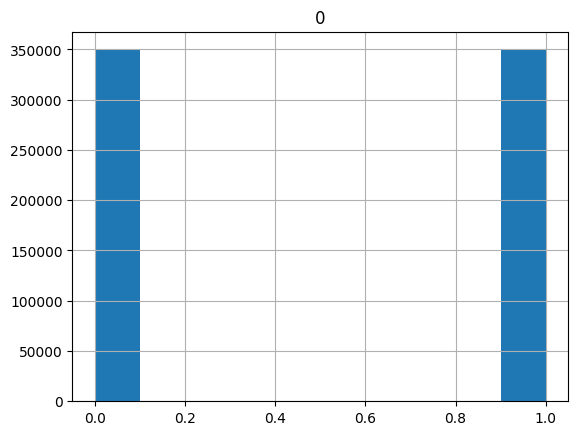

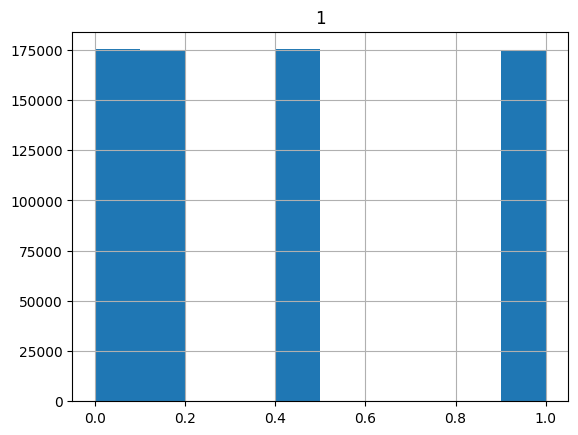

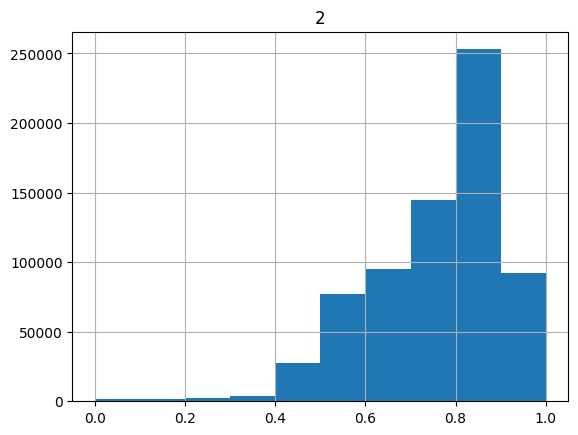

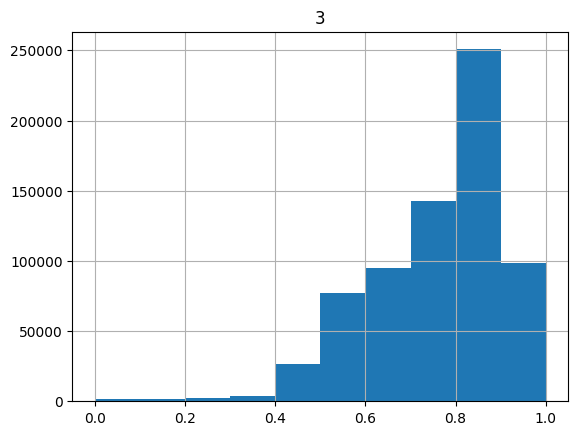

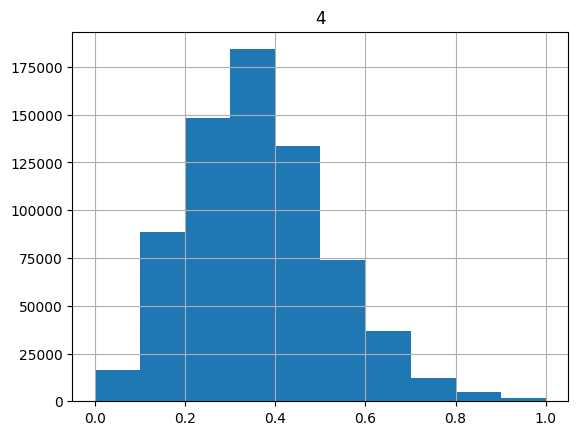

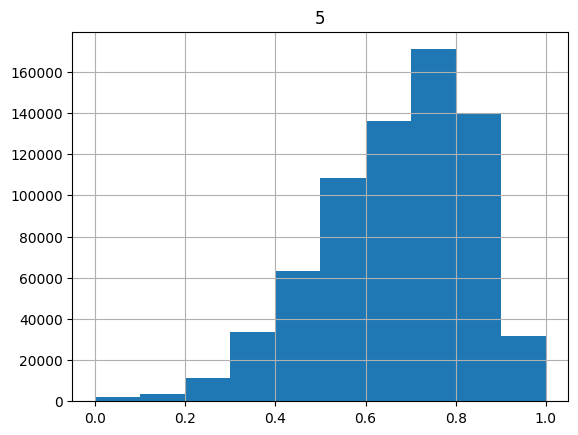

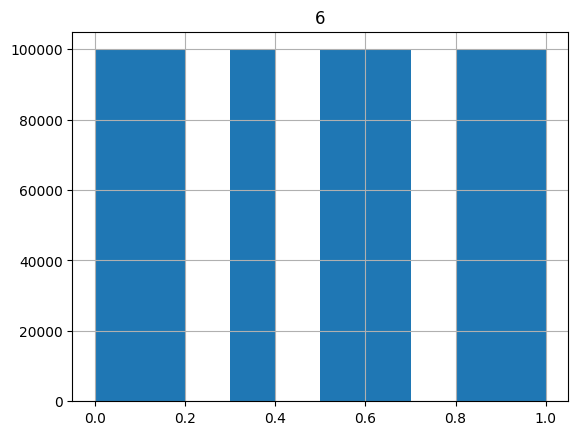

In [ ]:
dataRefinadoNewXNormalizado.hist(column=0)
dataRefinadoNewXNormalizado.hist(column=1)
dataRefinadoNewXNormalizado.hist(column=2)
dataRefinadoNewXNormalizado.hist(column=3)
dataRefinadoNewXNormalizado.hist(column=4)
dataRefinadoNewXNormalizado.hist(column=5)
dataRefinadoNewXNormalizado.hist(column=6)